# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [15]:
%load_ext autoreload
%autoreload 2

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup   
2. Human 3.6M Dataset
<br> 2.1. Summary of the dataset
<br> 2.2. Preparing the dataset
<br> 2.3. Visualizing poses
3. Model building approach
4. Baseline 1 - SimplePose (Simple ML model without using GNNs)
5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs) 
6. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)
7. Improvement 2 - PoseGCN model (Tweaks of SemGCN)
8. Evaluation & Analysis of models
9. Creating our own custom dataset
10. Evaluation on custom dataset
11. Conclusion
12. Video presentation & Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1 Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is a critical task for many applications such as motion capture and activity recognition. Traditional methods that use direct regression or lifting techniques often struggle to fully capture the complex spatial relationships between body joints. By treating the 2D pose keypoints as graphs, we can leverage the underlying connectivity between joints to improve the 3D pose estimation. Additionally, recognizing and classifying human activities from these poses is an essential task in fields like surveillance and healthcare. Therefore, this project seeks to explore how GNNs can enhance 3D pose estimation and activity recognition.

<h3><u>1.2 Project Description</h3></u>

The primary objective of this project is to predict 3D human poses from 2D pose keypoints accurately using GNNs. 
* Firstly, we will develop two baseline models: one using standard Neural Network (NN) & Convolutional Neural Network (CNN) followed by a simple GNN based model both for 3d pose estimation 
* Secondly, we will reimplement the SemGCN model, which treats the body joints of a 2D pose as nodes in a graph, with edges representing the connectivity between them. 
* Finally, we will design an improved version of the SemGCN model by exploring different GNN architectures and modifications to enhance its performance.

The secondary objective is to classify human activities based on 2D pose keypoints. We will use custom datasets to validate this task, allowing us to assess the generalization capabilities of GNN-based models for activity recognition.

<h3><u>1.3 Project Setup</u></h3>

1. Install the dependencies from requirements.txt using the command

`pip install -r requirements.txt`


<h2><u>2. Human 3.6M Dataset</u></h2>

<h3><u>2.1 Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a large-scale collection of 3.6 million 3D human poses captured from 11 professional actors in 17 everyday scenarios (e.g., talking, smoking, discussing). It includes synchronized video from multiple calibrated cameras, precise 3D joint positions and angles, and pixel-level body part labels. Additional data like time-of-flight range data and 3D laser scans of actors are also available.

The dataset comes with precomputed image descriptors, tools for visualizing and predicting human poses, and an evaluation set for benchmarking performance, making it a rich resource for 3D human pose estimation, action recognition, and related computer vision tasks.

<h3><u>2.2. Dataset preparation </u></h3>

Downloading the dataset from the website requires a login , therefore we will be directly using a preprocessed version of this dataset stored in google drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).
 
Original preprocessing was done by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) from this repository.

The cells below go through the steps of downloading this preprocessed dataset and creating train-test files from it after some transformation. 

From section 3(Models) we will be directly using the created train-test files, therefore the cells under this section need not be executed.

#### Downloading the zip from google drive

In [16]:
# Download the zip from google drive
import gdown
import os

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s
From (redirected): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s&confirm=t&uuid=54127ade-90db-48c1-b26f-07062abdd60e
To: d:\nus\Poseidon\datasets\h36m\Original\h36m.zip
100%|██████████| 260M/260M [00:16<00:00, 15.8MB/s] 


Downloaded ZIP file and saved to d:\nus\Poseidon\datasets\h36m\Original\h36m.zip


#### Extracting the contents into the same folder

In [17]:
# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")



Extracting files to d:\nus\Poseidon\datasets\h36m\Original..
Finished extracting files to d:\nus\Poseidon\datasets\h36m\Original


#### Saving the 3d positions into a compressed np file

In [18]:
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output


Processing subjects..: 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Saving compressed 3d positions into d:\nus\Poseidon\datasets\h36m\Original\data_3d_h36m
Finished saving 3d positions into d:\nus\Poseidon\datasets\h36m\Original\data_3d_h36m


#### Compute the ground truth 2d poses.

TODO.brandon explain what the human35mDataset constructor does in detail (intrinsics, extrinsics, cameras, normalization etc etc)

In [19]:
from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

Computing ground-truth 2D poses...
Saving compressed 2d positions into d:\nus\Poseidon\datasets\h36m\Original\data_2d_h36m_gt
Done saving compressed 2d positions into d:\nus\Poseidon\datasets\h36m\Original\data_2d_h36m_gt


#### Cleanup the extracted files and the downloaded zip

In [20]:
from shutil import rmtree

rmtree(os.path.join(folder_path, 'h36m'))
os.remove(os.path.join(folder_path, 'h36m.zip'))

#### Creating and saving train and test files from the saved npz files

In [21]:
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
import os

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)


In [22]:
#TODO.brandon: add comments for what exactly the read_3d_data function does and the create_2d_data does.
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

Reading 3d npz file
Reading 2d npz file
Done


In [23]:
print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path)
print("Done")

Creating train datasets and saving into file
Saved pose actions in file d:\nus\Poseidon\datasets\h36m\Processed\train_actions.npy
Saved 3d poses in file d:\nus\Poseidon\datasets\h36m\Processed\train_3d_poses.npy
Saved 2d poses in file d:\nus\Poseidon\datasets\h36m\Processed\train_2d_poses.npy
Creating test datasets and saving into file
Saved pose actions in file d:\nus\Poseidon\datasets\h36m\Processed\test_actions.npy
Saved 3d poses in file d:\nus\Poseidon\datasets\h36m\Processed\test_3d_poses.npy
Saved 2d poses in file d:\nus\Poseidon\datasets\h36m\Processed\test_2d_poses.npy
Done


<h3><u>2.3 Visualizing poses </u></h3>

Since we have saved the train and test files, we will now only use those files for the rest of the notebook.

This has also been saved directly in this [google drive link](https://drive.google.com/drive/folders/1d38hWSM8clZlI11nqljxBECog1KY-iTd?usp=sharing), which can be placed directly in the local path instead of executing previous cells.

The visualizations below shows that we are considering that human poses are comprised of skeletons with just 16 joints after doing all of the processing above.

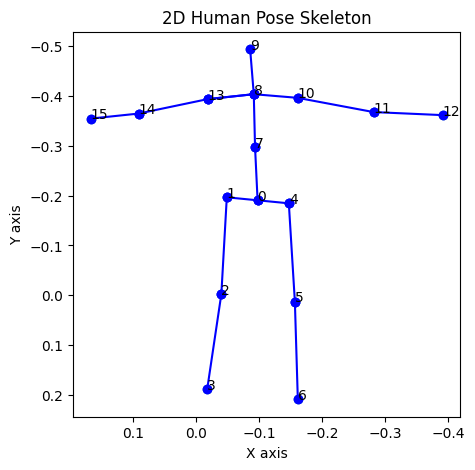

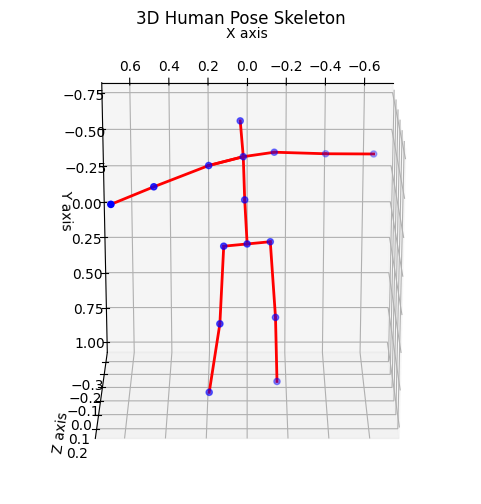

In [24]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

#### Finding out the distribution of actions in the train and test splits

The following code cells plots a bar graph of the actions in the train and test datasets.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def show_action_stats(actions, type):
    train_actions_df = pd.DataFrame(train_actions, columns=['actions'])
    action_counts = train_actions_df['actions'].value_counts()
    print(action_counts)
    
    action_counts.plot(kind='bar')
    
    # Step 4: Show the plot
    plt.title(f'{type} Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


actions
Discussion      158788
Smoking         133252
Walking         132744
SittingDown     129232
Sitting         116472
Phoning         115832
Waiting         115296
Eating          109424
Directions      100936
WalkTogether     87332
WalkDog          79412
Photo            76048
Greeting         72436
Posing           69468
Purchases        63080
Name: count, dtype: int64


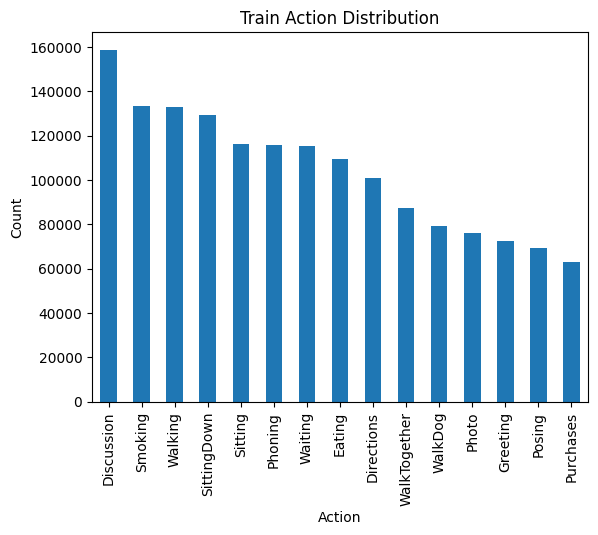

In [26]:
train_actions = np.load("datasets/h36m/Processed/train_actions.npy")
show_action_stats(train_actions, "Train")

actions
Discussion      158788
Smoking         133252
Walking         132744
SittingDown     129232
Sitting         116472
Phoning         115832
Waiting         115296
Eating          109424
Directions      100936
WalkTogether     87332
WalkDog          79412
Photo            76048
Greeting         72436
Posing           69468
Purchases        63080
Name: count, dtype: int64


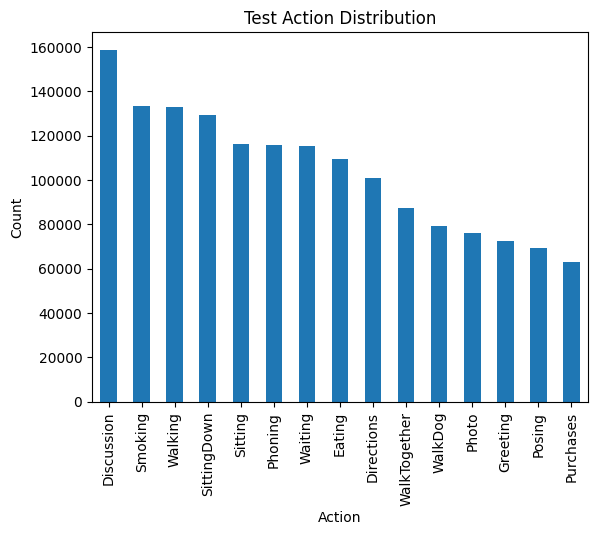

In [27]:
test_actions = np.load("datasets/h36m/Processed/test_actions.npy")
show_action_stats(train_actions, "Test")

<h2><u>3. Model Building Approach</u></h2>

The following sections attempts to build different ML models using the dataset which was just constructed above.

At a very high level these are the models we aim to build:
* SimplePose - A simple baseline ML model using classic DL layers
* SimplePoseGNN - A simple baseline GNN model using DGL and GNN layers
* SemGCN - A reimplementation of the [SemGCN paper](https://arxiv.org/abs/1904.03345) in DGL
* PoseGCN - A more complex GNN model by leveraging the insights gained from building the other GNN models.


<h2><u>4. Baseline 1 - SimplePose (Simple ML model without using GNNs)</u></h2>

TODO.brian - push all of the code to the appropriate files and give a brief description of the model built ( diagrams are good too)

In [30]:
from src.simple_pose.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 1e-3,
    'num_epochs': 200,
    'epoch_report': 10,
    'batch_size': 64,
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'h36m', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose', timestamp)
}
args = Namespace(**args_dict)
training_loop(args)

INFO:root:Creating Missing Paths: model_outputs\simple_pose\2024-10-25--11-13-57
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePose model with Kaiming Weights
INFO:root:Setup Optimizer
INFO:root:Setup Scheduler
INFO:root:Setup loss functions
  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 2

<h2><u>5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs)</u></h2>

TODO.brandon

<h2><u>6. Improvement 1 - SemGCN model (Reimplementation of Semantic GCN)</u></h2>

TODO.parash


<h2><u>7. Improvement 2 - PoseGCN model (Tweaks of SemGCN)</u></h2>

TODO.all

<h2><u>8. Evaluation & Analysis of models<u></h2>

<h2><u>9. Creating our own custom dataset</u></h2>

<h2><u>10. Evaluation on custom dataset</u></h2>

<h2><u>11. Conclusion</u></h2>

<h2><u>12. Video presentation & Resources</u></h2>